In [1]:
from shared_notebook_utils import *
datasets = load_datasets(dirnames=['freesound_loops_db_4000'], clean=True)
dataset = datasets[0]
%matplotlib inline

# This notebook contains expriments that complement those found in the article: Font, F., & Serra, X. (2016). Tempo Estimation for Music Loops and a Simple Confidence Measure. In Proceedings of the Int. Conf. on Music Information Retrieval (ISMIR).
# License: CC-BY-4.0

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


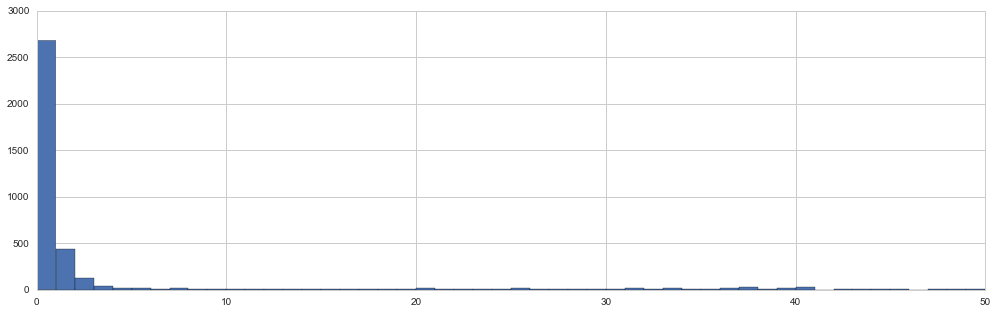

(ROUNDED) 1261 produce different results, 2681 produce same results (31.99% different)
(FLOAT, 0.1 max dif) 1529 produce different results, 2413 produce same results (38.79% different)


In [2]:
# Evaluate how differnt the ouputs of the two algorithms are
bpm_round_diffs = list()
bpm_diffs = list()
sounds = list()
for sound in dataset.data.values():
    try:
        percival14mod_bpm = sound['analysis']['Percival14Mod']['bpm']
        percival14essentia_bpm = sound['analysis']['Percival14_essentia']['bpm']
        bpm_round_diffs.append(round(percival14mod_bpm) - round(percival14essentia_bpm))
        bpm_diffs.append(percival14mod_bpm - percival14essentia_bpm)
        sounds.append(sound)
    except KeyError:
        # Loop could not be analysed with both algorithms, continue
        continue

fig1, axs = plt.subplots(1, 1, figsize=(17, 5))
plt.hist([abs(i) for i in bpm_round_diffs], bins=50, range=(0,50))
plt.show()

# Considering rounded bpms
n_different = len(np.where(np.array([abs(i) for i in bpm_round_diffs])>0)[0])
n_same = len(np.where(np.array([abs(i) for i in bpm_round_diffs])==0)[0])
print '(ROUNDED) %i produce different results, %i produce same results (%.2f%% different)' % (n_different, n_same, 100.0*(n_different)/(n_different+n_same))

# Considering float bpms
n_different = len(np.where(np.array([abs(i) for i in bpm_diffs])>0.1)[0])
n_same = len(np.where(np.array([abs(i) for i in bpm_diffs])<=0.1)[0])
print '(FLOAT, 0.1 max dif) %i produce different results, %i produce same results (%.2f%% different)' % (n_different, n_same, 100.0*(n_different)/(n_different+n_same))


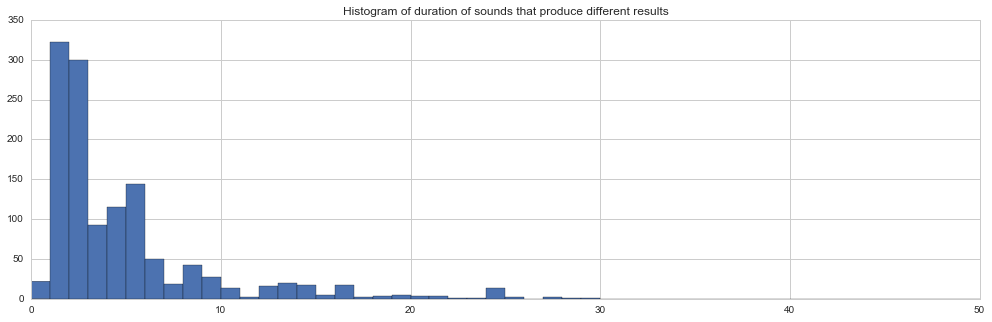

Most of the sounds that produce different results are under 6s duration.


In [3]:
# Check length of sounds that produce different results

indices = np.where(np.array([abs(i) for i in bpm_round_diffs])>0)[0]
durations = [sounds[idx]['analysis']['durations']['duration'] for idx in indices]
fig, axs = plt.subplots(1, 1, figsize=(17, 5))
plt.hist(durations, bins=50, range=(0,50))
plt.title('Histogram of duration of sounds that produce different results')
plt.show()

print 'Most of the sounds that produce different results are under 6s duration.'

In [4]:
# Select a sound that produces different results
#indices = np.where(np.array([abs(i) for i in bpm_diffs])==0.0)[0]
indices = np.where(np.array([abs(i) for i in bpm_diffs])>0.1)[0]
import random
random.shuffle(indices)
sound = sounds[indices[0]]
sound_id = sound['id']
print 'Selected sound with id %s (from %i sounds)' % (sound_id, len(indices))
sample_rate = 44100
audio = load_audio_file(file_path=dataset.get_sound_path(sound_id), sample_rate=sample_rate)
print 'Length: %i' % audio.shape[0]

# Run Percival14Mod method and gather intermediate data
from algorithms.Percival14Mod.defs_class import Defs
from algorithms.Percival14Mod.onset_strength import onset_strength_signal
from algorithms.Percival14Mod.beat_period_detection import beat_period_detection
from algorithms.Percival14Mod.accumulator_overall import accumulator_overall
pythonData = dict()
defs = Defs()
oss_sr, oss_data = onset_strength_signal(defs, sample_rate, audio, plot=False)
tempo_lags, peaks, autocorr, harmonic_enhanced, oss_overlapped = beat_period_detection(defs, oss_sr, oss_data, plot=False, intermediate_data=True)
bpm, accum, mult = accumulator_overall(defs, tempo_lags, oss_sr, intermediate_data=True)
pythonData = {
    'oss': oss_data,
    'oss_overlapped': oss_overlapped,
    'peaks': peaks,
    'autocorr': autocorr,
    'harmonic_enhanced': harmonic_enhanced,
    'tempo_lags': tempo_lags,
    'accum': accum,
    'mult': mult,
    'bpm': bpm,
}
print 'Python', pythonData['bpm']

# Delete temporary files starting with __d_*
files_to_delete = [filename for filename in os.listdir('.') if filename.startswith('__d_')]
for filename in files_to_delete:
    os.remove(filename)
    
# Util function, load data form file
def load_data(filename):
    fid = open(filename, 'r')
    parsed_data = list()
    for line in fid:
        parsed_data.append(json.loads(line))
    return np.array(parsed_data)
        
# Run Percival14_essentia method and gather intermediate data
import essentia.standard as estd
essentiaData = dict()
tempo_estimator = estd.PercivalBpmEstimator()
bpm = tempo_estimator(audio)
essentiaData['bpm'] = bpm
try:
    essentiaData['oss'] = load_data('__d_oss.txt')[0]
    essentiaData['oss_overlapped'] = load_data('__d_oss_overlapped.txt')
    essentiaData['peaks'] = load_data('__d_peaks.txt')
    essentiaData['autocorr'] = load_data('__d_autocorr.txt')
    essentiaData['harmonic_enhanced'] = load_data('__d_enhance_harmonics.txt')
except IOError:
    print 'Could not load some (or any) essentia data'

print 'Essentia', essentiaData['bpm']

Selected sound with id 276071 (from 1529 sounds)
Length: 82687
Python 128.39673913
Could not load some (or any) essentia data
Essentia 127.604164124


In [5]:
# NOTE: this cell will fail if the essentia algorithm does not include hooks for writing intermediate values to files

# Compare oss
for prop_name in ['oss']:
    if len(essentiaData[prop_name]) != len(pythonData[prop_name]):
        print '[%s] Essentia and python data have different length... (%i and %i resp.)' % (prop_name, len(essentiaData[prop_name]), len(pythonData[prop_name]))

fig, axs = plt.subplots(1, 1, figsize=(17, 5))
plt.title('OSS')
plt.plot(essentiaData['oss'], color='red')
plt.plot(pythonData['oss'], color='blue')
#plt.axis([0, 500, 0, 16])
plt.show()    

KeyError: 'oss'

In [6]:
# NOTE: this cell will fail if the essentia algorithm does not include hooks for writing intermediate values to files

# Compare enhance harmonics and peak picking
for prop_name in ['harmonic_enhanced', 'peaks']:
    if len(essentiaData[prop_name]) != len(pythonData[prop_name]):
        print '[%s] Essentia and python data have different length... (%i and %i resp.)' % (prop_name, len(essentiaData[prop_name]), len(pythonData[prop_name]))

for frame in range(0, min(len(essentiaData['harmonic_enhanced']), len(pythonData['harmonic_enhanced'])))[0:3]:           
    fig, axs = plt.subplots(1, 1, figsize=(17, 5))
    plt.title('Frame %i (SIGNAL)' % frame)
    plt.plot(essentiaData['oss_overlapped'][frame], color='red')
    plt.plot(pythonData['oss_overlapped'][frame], color='blue')
    
    fig, axs = plt.subplots(1, 1, figsize=(17, 5))
    plt.title('Frame %i (AUTOCORR)' % frame)
    plt.plot(essentiaData['autocorr'][frame], color='red')
    plt.vlines(essentiaData['peaks'][frame], 0, 500, color='red')
    plt.plot(pythonData['autocorr'][frame], color='blue')
    plt.vlines(pythonData['peaks'][frame], 0, 500, color='blue')
    plt.axis([80, 400, 0, 1.2 * max(pythonData['autocorr'][frame][80:400])])

plt.show()    


KeyError: 'harmonic_enhanced'

In [9]:
# Now we compare output of the confidence measure computed in python or in essentia
def compute_confidence_measure_python(estimated_bpm, sound):
    sample_rate=44100 
    beat_range=range(1, 128)
    k=0.5
    duration_samples = sound['analysis']['durations']['length_samples']
    start_effective_duration = sound['analysis']['durations']['start_effective_duration']
    end_effective_duration = sound['analysis']['durations']['end_effective_duration']
    
    if estimated_bpm == 0:
        # This condition is to skip computing other steps if estimated bpm is 0, we already know that the
        # output will be 0
        return 0

    durations_to_check = [
        duration_samples,
        duration_samples - start_effective_duration,
        end_effective_duration,
        end_effective_duration - start_effective_duration
    ]

    beat_duration = (60.0 * sample_rate)/estimated_bpm
    L = [beat_duration * n for n in beat_range]
    thr_lambda = k * beat_duration
    confidences = list()
    for duration in durations_to_check:
        delta_l = min([abs(l - duration) for l in L])
        if delta_l > thr_lambda:
            confidences.append(0.0)
        else:
            confidences.append(1.0 - float(delta_l) / thr_lambda)
    return max(confidences)

def compute_confidence_measure_essentia(estimated_bpm, audio):
    confidence_algorithm = estd.LoopBpmConfidence()
    return confidence_algorithm(audio, estimated_bpm)


diffs = list()
for sound in sounds[0:100]:
    estimated_bpm = sound['analysis']['Percival14Mod']['bpm']  # We use same value for estimation
    sample_rate = 44100
    audio = load_audio_file(file_path=dataset.get_sound_path(sound['id']), sample_rate=sample_rate)
    confidence_essentia = compute_confidence_measure_essentia(estimated_bpm, audio)
    confidence_python = compute_confidence_measure_python(estimated_bpm, sound)
    diffs = abs(confidence_essentia - confidence_python)

print 'Average difference of confidence measures: %.8f' % np.mean(diffs)
    

Average difference of confidence measures: 0.00000002
